In [12]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
# 여러 txt 파일 읽어오기
def process_files(file_list):
    results = []

    # 각 파일을 읽어와서 데이터 처리
    for file in file_list:
        with open(file, 'r') as f:
            data = f.read()

        # 정규 표현식으로 dataset, 모델명, 학습 유형(ftS, ftMS), Exp, mse, mae, rse 추출
        pattern = re.compile(r"(\w+)_\d+_(\w+)_custom_(ftS|ftMS).*_Exp_(\d+)\s+mse:([\d\.]+),\s+mae:([\d\.]+),\s+rse:([\d\.]+)")

        # 텍스트에서 여러 실험 결과 정보 추출
        matches = pattern.findall(data)

        # 추출된 정보에서 각 값을 리스트에 추가
        for match in matches:
            # Dataset에서 숫자 부분 제거 (예: 'Milano_48' -> 'Milano')
            dataset = re.sub(r'_\d+', '', match[0])
            model, learning_type, exp, mse, mae, rse = match[1:]
            results.append([dataset, model, learning_type, f"Exp{exp}", float(mse), float(mae), float(rse)])

    # pandas DataFrame 생성
    df = pd.DataFrame(results, columns=['Dataset', 'Model', 'Learning Type', 'Experiment', 'MSE', 'MAE', 'RSE'])

    return df

이 곳에서 데이터 셋에 따라서 결과물을 다르게 확인가능

In [14]:
# 처리할 파일 리스트 (파일 경로 입력)
file_Milano_list = ['/home/work/.default/hyunwoong/CICD_comparision/archive/Milano/cnn/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/Milano/linear/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/Milano/rnn/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/Milano/transformer/result.txt']

# 처리할 파일 리스트 (파일 경로 입력)
file_Traffic_list = ['/home/work/.default/hyunwoong/CICD_comparision/archive/traffic/cnn/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/traffic/linear/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/traffic/rnn/result.txt',
             '/home/work/.default/hyunwoong/CICD_comparision/archive/traffic/transformer/result.txt']

In [15]:
# 파일 처리 후 DataFrame 생성
df = process_files(file_Milano_list)

# DataFrame 출력
print(df)

    Dataset       Model Learning Type Experiment       MSE       MAE       RSE
0    Milano     TSMixer           ftS       Exp0  0.078570  0.202270  0.299618
1    Milano     TSMixer           ftS       Exp1  0.084907  0.210547  0.311465
2    Milano     TSMixer           ftS       Exp2  0.085260  0.210597  0.312113
3    Milano     TSMixer           ftS       Exp3  0.082038  0.206266  0.306158
4    Milano     TSMixer           ftS       Exp4  0.080247  0.204297  0.302798
..      ...         ...           ...        ...       ...       ...       ...
255  Milano  Pyraformer           ftS       Exp5  0.095363  0.220045  0.330088
256  Milano  Pyraformer           ftS       Exp6  0.093619  0.221185  0.327055
257  Milano  Pyraformer           ftS       Exp7  0.095425  0.220664  0.330195
258  Milano  Pyraformer           ftS       Exp8  0.092512  0.218608  0.325115
259  Milano  Pyraformer           ftS       Exp9  0.091380  0.215572  0.323120

[260 rows x 7 columns]


In [16]:
# 같은 Model과 Learning Type별로 평균(mean)과 표준편차(std) 계산
summary_df = df.groupby(['Model', 'Learning Type']).agg(
    MSE_mean=('MSE', 'mean'), MSE_std=('MSE', 'std'),
    MAE_mean=('MAE', 'mean'), MAE_std=('MAE', 'std'),
    RSE_mean=('RSE', 'mean'), RSE_std=('RSE', 'std')
).reset_index()

# 결과 출력
print(summary_df)

          Model Learning Type  MSE_mean   MSE_std  MAE_mean   MAE_std  \
0    Autoformer          ftMS  0.440468  0.061591  0.506732  0.031188   
1    Autoformer           ftS  0.419068  0.061959  0.502625  0.041175   
2   Crossformer          ftMS  0.079470  0.004936  0.208251  0.006867   
3   Crossformer           ftS  0.089894  0.002708  0.218567  0.003819   
4       DLinear          ftMS  0.149880  0.004282  0.282963  0.003125   
5       DLinear           ftS  0.149880  0.004281  0.282964  0.003125   
6      Informer          ftMS  0.089739  0.004826  0.218214  0.006153   
7      Informer           ftS  0.098171  0.005306  0.229429  0.006164   
8        Linear          ftMS  0.156484  0.017848  0.289552  0.016004   
9        Linear           ftS  0.156479  0.017841  0.289546  0.015996   
10      NLinear          ftMS  0.377402  0.008734  0.417928  0.013188   
11      NLinear           ftS  0.377403  0.008734  0.417931  0.013192   
12     PatchTST          ftMS  0.149653  0.016243  

In [17]:
# Split the data by Learning Type
ftMS_data = summary_df[summary_df['Learning Type'] == 'ftMS']
ftS_data = summary_df[summary_df['Learning Type'] == 'ftS']

# Merge the two subsets (ftMS and ftS) on the 'Model' to compare them side by side
comparison_df = pd.merge(ftMS_data[['Model', 'MAE_mean']], ftS_data[['Model', 'MAE_mean']], on='Model', suffixes=('_ftMS', '_ftS'))

# Calculate the difference
comparison_df['MAE_difference'] = comparison_df['MAE_mean_ftMS'] - comparison_df['MAE_mean_ftS']

comparison_df

,Model,MAE_mean_ftMS,MAE_mean_ftS,MAE_difference
0,Autoformer,0.506732,0.502625,4.106861e-03
1,Crossformer,0.208251,0.218567,-1.031600e-02
2,DLinear,0.282963,0.282964,-1.013279e-07
3,Informer,0.218214,0.229429,-1.121493e-02
4,Linear,0.289552,0.289546,5.704165e-06
5,NLinear,0.417928,0.417931,-2.804399e-06
6,PatchTST,0.276310,0.275086,1.223862e-03
7,Pyraformer,0.212065,0.215345,-3.280005e-03
8,SegRNN,0.224416,0.223659,7.572845e-04
9,TSMixer,0.216501,0.209206,7.295243e-03


In [19]:
# ftMS와 ftS 성능 비교를 위해 ftMS와 ftS 데이터를 분리
df_ftMS = summary_df[summary_df['Learning Type'] == 'ftMS']
df_ftS = summary_df[summary_df['Learning Type'] == 'ftS']

# 각 모델별로 ftMS가 더 좋은 경우 선택 (MSE 기준)
better_ftMS_MSE = df_ftMS[(df_ftMS['MSE_mean'] < df_ftS['MSE_mean'].values)]
better_ftS_MSE = df_ftMS[(df_ftMS['MSE_mean'] > df_ftS['MSE_mean'].values)]

# 각 모델별로 ftMS가 더 좋은 경우 선택 (MAE 기준)
better_ftMS_MAE = df_ftMS[(df_ftMS['MAE_mean'] < df_ftS['MAE_mean'].values)]
better_ftS_MAE = df_ftMS[(df_ftMS['MAE_mean'] < df_ftS['MAE_mean'].values)]

# 각 모델별로 ftMS가 더 좋은 경우 선택 (RSE 기준)
better_ftMS_RSE = df_ftMS[(df_ftMS['RSE_mean'] < df_ftS['RSE_mean'].values)]
better_ftS_RSE = df_ftMS[(df_ftMS['RSE_mean'] < df_ftS['RSE_mean'].values)]

In [20]:
# 결과 출력
standard_list =[better_ftMS_MSE] #,better_ftMS_MAE,better_ftMS_RSE

for i in standard_list:
    print(i)
    print(i.shape)

          Model Learning Type  MSE_mean   MSE_std  MAE_mean   MAE_std  \
2   Crossformer          ftMS  0.079470  0.004936  0.208251  0.006867   
6      Informer          ftMS  0.089739  0.004826  0.218214  0.006153   
10      NLinear          ftMS  0.377402  0.008734  0.417928  0.013188   
14   Pyraformer          ftMS  0.084406  0.006861  0.212065  0.009861   
22     TimesNet          ftMS  0.072987  0.004970  0.199247  0.005891   
24  Transformer          ftMS  0.093206  0.004802  0.222020  0.005359   
26   VanillaRNN          ftMS  0.182699  0.009926  0.295986  0.007753   

    RSE_mean   RSE_std  
2   0.301199  0.009332  
6   0.320104  0.008536  
10  0.656622  0.007510  
14  0.310318  0.012529  
22  0.288646  0.009681  
24  0.326236  0.008377  
26  0.456738  0.012219  
(7, 8)


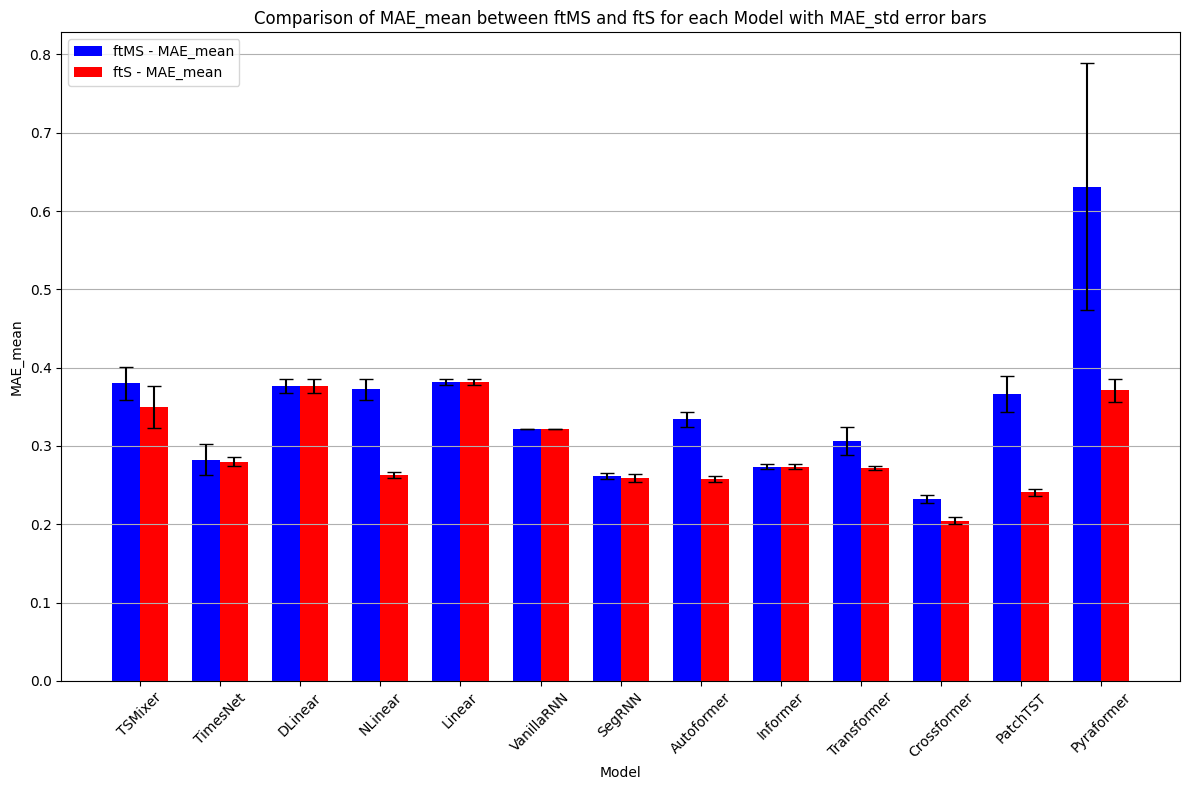

In [43]:
# 단순하게 모델별로 ftS, ftMS를 비교
# 성능의 차이가 크게 나는 것이 아니므로 MAE가 아닌 MSE로 설정한다.

# Bar width and positions
bar_width = 0.35
index = np.arange(len(summary_df['Model'].unique()))

# Split the data by Learning Type
ftMS_data = summary_df[summary_df['Learning Type'] == 'ftMS']
ftS_data = summary_df[summary_df['Learning Type'] == 'ftS']

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting with error bars for MAE_mean and MAE_std
plt.bar(index, ftMS_data['MAE_mean'], bar_width, yerr=ftMS_data.get('MAE_std', 0), label='ftMS - MAE_mean', color='b', capsize=5)
plt.bar(index + bar_width, ftS_data['MAE_mean'], bar_width, yerr=ftS_data.get('MAE_std', 0), label='ftS - MAE_mean', color='r', capsize=5)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('MAE_mean')
plt.title('Comparison of MAE_mean between ftMS and ftS for each Model with MAE_std error bars')

# Set the x-ticks to be in the middle of the bars
plt.xticks(index + bar_width / 2, df['Model'].unique(), rotation=45)

# Adding legend and grid
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()

# Show plot
plt.show()

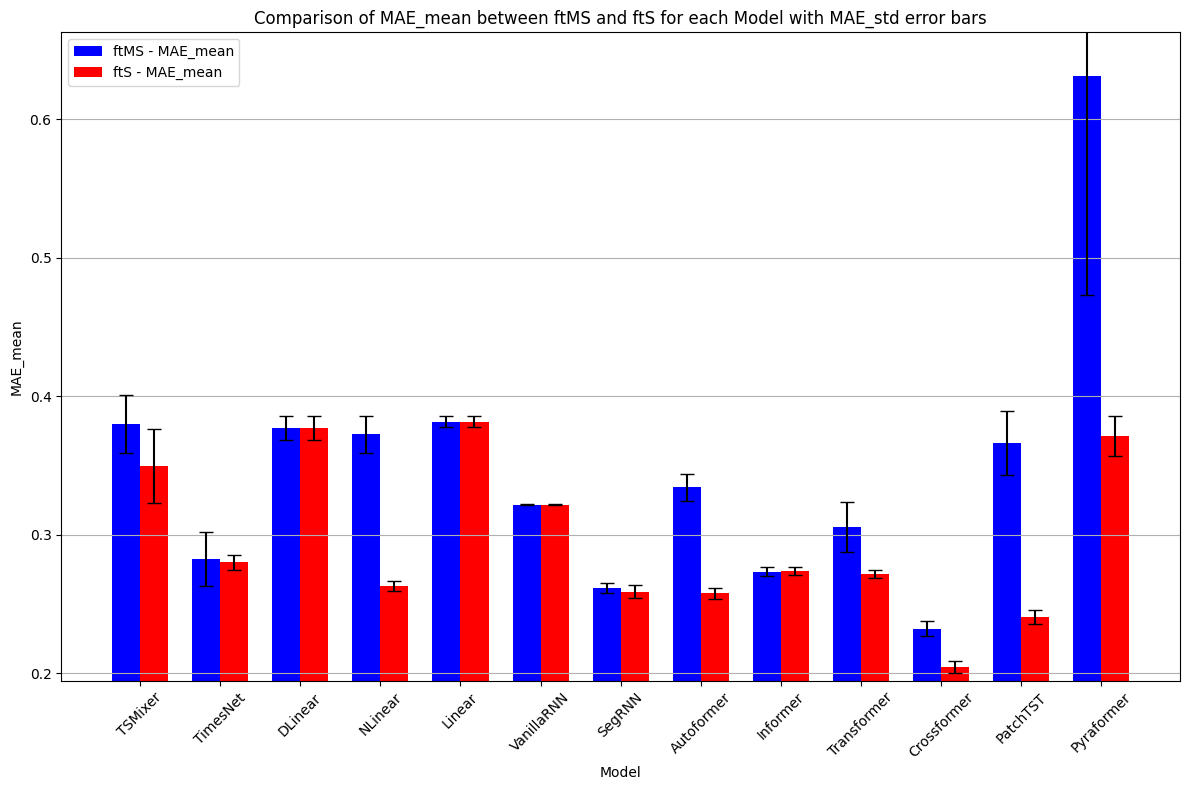

In [44]:
# Assuming 'MAE_std' exists in the dataframe, we'll now add error bars representing the standard deviation.

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the minimum and maximum values for MAE_mean with some padding
y_min = min(min(ftMS_data['MAE_mean']), min(ftS_data['MAE_mean'])) * 0.95
y_max = max(max(ftMS_data['MAE_mean']), max(ftS_data['MAE_mean'])) * 1.05

# Plotting with error bars for MAE_mean and MAE_std
plt.bar(index, ftMS_data['MAE_mean'], bar_width, yerr=ftMS_data.get('MAE_std', 0), label='ftMS - MAE_mean', color='b', capsize=5)
plt.bar(index + bar_width, ftS_data['MAE_mean'], bar_width, yerr=ftS_data.get('MAE_std', 0), label='ftS - MAE_mean', color='r', capsize=5)

# Adding labels and title
plt.xlabel('Model')
plt.ylabel('MAE_mean')
plt.title('Comparison of MAE_mean between ftMS and ftS for each Model with MAE_std error bars')

# Set the x-ticks to be in the middle of the bars, and rotate labels by 45 degrees
plt.xticks(index + bar_width / 2, df['Model'].unique(), rotation=45)

# Adjust the y-axis range based on the calculated min and max values
plt.ylim(y_min, y_max)

# Adding legend and grid
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()

# Show plot
plt.show()
